## Deterministic tractography

Deterministic tractography algorithms perform tracking of streamlines by following a predictable path, such as following the primary diffusion direction.

In order to demonstrate how to perform deterministic tracking on a diffusion MRI dataset, we will build from the preprocessing presented in a previous episode and compute the diffusion tensor.

In [1]:
import os

import nibabel as nib
import numpy as np

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table


dwi_layout = BIDSLayout(
    "../../../data/ds000221/derivatives/uncorrected_topup_eddy", validate=False)
gradient_layout = BIDSLayout("../../../data/ds000221/", validate=False)

subj = '010006'

dwi_fname = dwi_layout.get(subject=subj, suffix='dwi',
                           extension='nii.gz', return_type='file')[0]
bvec_fname = dwi_layout.get(
    subject=subj, extension='eddy_rotated_bvecs', return_type='file')[0]
bval_fname = gradient_layout.get(
    subject=subj, suffix='dwi', extension='bval', return_type='file')[0]

dwi_img = nib.load(dwi_fname)
affine = dwi_img.affine

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


We will now create a mask and constrain the fitting within the mask.

In [2]:
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu

dwi_data = dwi_img.get_fdata()
# Specify the volume index to the b0 volumes
dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)

dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi_data, mask=dwi_mask)  # This step may take a while

We will perform tracking using a deterministic algorithm on tensor fields via `EuDX` [(Garyfallidis _et al._, 2012)](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3518823/). `EuDX` makes use of the primary direction of the diffusion tensor to propagate streamlines from voxel to voxel and a stopping criteria from the fractional anisotropy (FA). 

We will first get the FA map and eigenvectors from our tensor fitting. In the background of the FA map, the fitting may not be accurate as all of the measured signal is primarily noise and it is possible that values of NaNs (not a number) may be found in the FA map. We can remove these using `numpy` to find and set these voxels to 0.

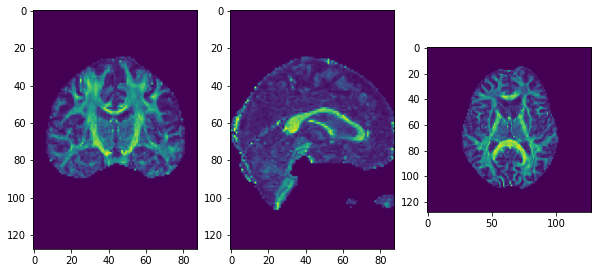

In [3]:
# Create the directory to save the results

from scipy import ndimage  # To rotate image for visualization purposes
import matplotlib.pyplot as plt
out_dir = "../../../data/ds000221/derivatives/dwi/tractography/sub-%s/ses-01/dwi/" % subj

if not os.path.exists(out_dir):
    os.makedirs(out_dir)

fa_img = dti_fit.fa
evecs_img = dti_fit.evecs

fa_img[np.isnan(fa_img)] = 0

# Save the FA
fa_nii = nib.Nifti1Image(fa_img.astype(np.float32), affine)
nib.save(fa_nii, os.path.join(out_dir, 'fa.nii.gz'))

# Plot the FA

%matplotlib inline

fig, ax = plt.subplots(1, 3, figsize=(10, 10))
ax[0].imshow(ndimage.rotate(
    fa_img[:, fa_img.shape[1]//2, :], 90, reshape=False))
ax[1].imshow(ndimage.rotate(
    fa_img[fa_img.shape[0]//2, :, :], 90, reshape=False))
ax[2].imshow(ndimage.rotate(
    fa_img[:, :, fa_img.shape[-1]//2], 90, reshape=False))
fig.savefig(os.path.join(out_dir, "fa.png"), dpi=300, bbox_inches="tight")
plt.show()

One of the inputs of `EuDX` is the discretized voxel directions on a unit sphere. Therefore, it is necessary to discretize the eigenvectors before providing them to `EuDX`. We will use an evenly distributed sphere of 362 points using the `get_sphere` function.

In [4]:
from dipy.data import get_sphere

sphere = get_sphere('symmetric362')

We will determine the indices representing the discretized directions of the peaks by providing as input, our tensor model, the diffusion data, the sphere, and a mask to apply the processing to. Additionally, we will set the minimum angle between directions, the maximum number of peaks to return (1 for the tensor model), and the relative peak threshold (returning peaks greater than this value).

_Note: This step may take a while to run._

In [5]:
from dipy.direction import peaks_from_model

peak_indices = peaks_from_model(model=dti_model, data=dwi_data, sphere=sphere,
                                relative_peak_threshold=.2, min_separation_angle=25, mask=dwi_mask, npeaks=2)

Additionally, we will apply a stopping criterion for our tracking based on the FA map. That is, we will stop our tracking when we reach a voxel where FA is below 0.2.

In [6]:
from dipy.tracking.stopping_criterion import ThresholdStoppingCriterion

stopping_criterion = ThresholdStoppingCriterion(fa_img, .2)

We will also need to specify where to "seed" (begin) the fiber tracking. Generally, the seeds chosen will depend on the pathways one is interested in modelling. In this example, we will create a seed mask from the FA map thresholding above our stopping criterion.

In [7]:
from dipy.tracking import utils

seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=affine, density=1)

Now, we can apply the tracking algorithm! 

As mentioned previously, `EuDX` is the fiber tracking algorithm that we will be using. The most important parameters to include are the indices representing the discretized directions of the peaks (`peak_indices`), the stopping criterion, the seeds, the affine transformation, and the step sizes to take when tracking!

In [8]:
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

# Initialize local tracking - computation happens in the next step.
streamlines_generator = LocalTracking(
    peak_indices, stopping_criterion, seeds, affine=affine, step_size=.5)

# Generate streamlines object
streamlines = Streamlines(streamlines_generator)

We just created a deterministic set of streamlines using the `EuDX` algorithm mapping the human connectome (tractography). We can save the streamlines as a Trackvis file so it can be loaded into other software for visualization or further analysis. To do so, we need to save the tractogram state using `StatefulTractogram` and `save_tractogram` to save the file. Note that we will have to specify the space to save the tractogram in.

In [9]:
from dipy.io.stateful_tractogram import Space, StatefulTractogram
from dipy.io.streamline import save_tractogram

sft = StatefulTractogram(streamlines, dwi_img, Space.RASMM)

# Save the tractogram
save_tractogram(sft, os.path.join(
    out_dir, "tractogram_deterministic_EuDX.trk"))

True

We can then generate the streamlines 3D scene using the `fury` python package, and visualize the scene's contents with `matplotlib`.

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/fury/utils.py:97: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array(data)


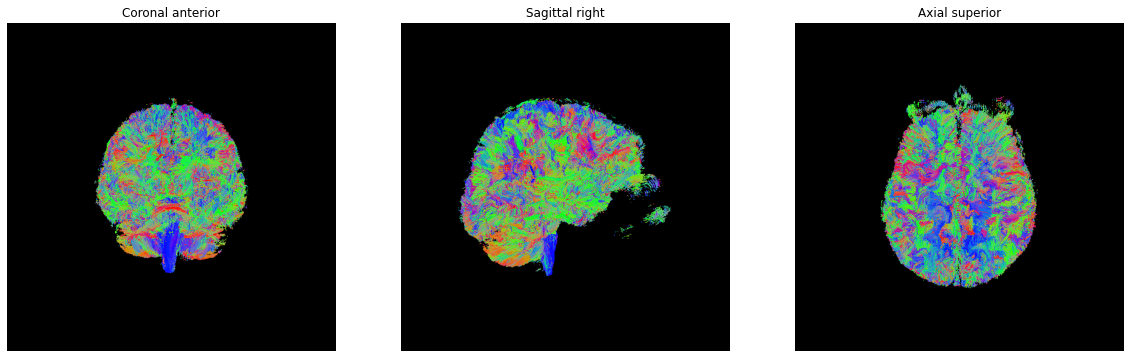

In [10]:
# NBVAL_SKIP
from utils.visualization_utils import generate_anatomical_volume_figure
from fury import actor, colormap

# Plot the tractogram

# Build the representation of the data
streamlines_actor = actor.line(streamlines, colormap.line_colors(streamlines))

# Generate the figure
fig = generate_anatomical_volume_figure(streamlines_actor)

fig.savefig(os.path.join(out_dir, "tractogram_deterministic_EuDX.png"),
            dpi=300, bbox_inches="tight")
plt.show()

## Exercise 1

In this episode, we sapplied a threshold stopping criteria
to stop tracking when we reach a voxel where FA is below 0.2.
There are also other stopping criteria available. We encourage
you to read the `DIPY` documentation about the others. For this
exercise, repeat the tractography, but apply a binary stopping 
criteria (`BinaryStoppingCriterion`) using the seed mask.

## Solution

In [11]:
import os

import nibabel as nib
import numpy as np

from bids.layout import BIDSLayout

from dipy.io.gradients import read_bvals_bvecs
from dipy.core.gradients import gradient_table
from dipy.data import get_sphere
from dipy.direction import peaks_from_model
import dipy.reconst.dti as dti
from dipy.segment.mask import median_otsu
from dipy.tracking import utils
from dipy.tracking.stopping_criterion import BinaryStoppingCriterion
from dipy.tracking.local_tracking import LocalTracking
from dipy.tracking.streamline import Streamlines

dwi_layout = BIDSLayout(
    "../../../data/ds000221/derivatives/uncorrected_topup_eddy", validate=False)
gradient_layout = BIDSLayout("../../../data/ds000221/", validate=False)

# Get subject data
subj = '010006'
dwi_fname = dwi_layout.get(subject=subj, suffix='dwi',
                           extension='nii.gz', return_type='file')[0]
bvec_fname = dwi_layout.get(
    subject=subj, extension='eddy_rotated_bvecs', return_type='file')[0]
bval_fname = gradient_layout.get(
    subject=subj, suffix='dwi', extension='bval', return_type='file')[0]

dwi_img = nib.load(dwi_fname)
affine = dwi_img.affine

bvals, bvecs = read_bvals_bvecs(bval_fname, bvec_fname)
gtab = gradient_table(bvals, bvecs)

dwi_data = dwi_img.get_fdata()
# Specify the volume index to the b0 volumes
dwi_data, dwi_mask = median_otsu(dwi_data, vol_idx=[0], numpass=1)

# Fit tensor and compute FA map
dti_model = dti.TensorModel(gtab)
dti_fit = dti_model.fit(dwi_data, mask=dwi_mask)
fa_img = dti_fit.fa
evecs_img = dti_fit.evecs

sphere = get_sphere('symmetric362')
peak_indices = peaks_from_model(model=dti_model, data=dwi_data, sphere=sphere,
                                relative_peak_threshold=.2, min_separation_angle=25, mask=dwi_mask, npeaks=2)

# Create a binary seed mask
seed_mask = fa_img.copy()
seed_mask[seed_mask >= 0.2] = 1
seed_mask[seed_mask < 0.2] = 0

seeds = utils.seeds_from_mask(seed_mask, affine=affine, density=1)

# Set stopping criteria
stopping_criterion = BinaryStoppingCriterion(seed_mask == 1)

# Perform tracking
streamlines_generator = LocalTracking(
    peak_indices, stopping_criterion, seeds, affine=affine, step_size=.5)
streamlines = Streamlines(streamlines_generator)

/home/ROBARTS/tkai/.local/lib/python3.6/site-packages/bids/layout/models.py:152: FutureWarning: The 'extension' entity currently excludes the leading dot ('.'). As of version 0.14.0, it will include the leading dot. To suppress this warning and include the leading dot, use `bids.config.set_option('extension_initial_dot', True)`.
  FutureWarning)


## Exercise 2

Visualize the tractogram! As an additional challenge, set the
color of the streamlines to display the values of the
FA map and change the opacity to `0.05`. You may need to transform the streamlines from world coordinates to the subject's native space using `transform_streamlines` from `dipy.tracking.streamline`.

## Solution

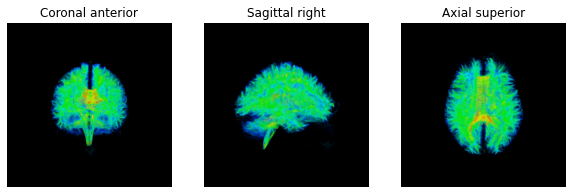

In [15]:
import numpy as np
from fury import actor, window

from dipy.tracking.streamline import transform_streamlines

streamlines_native = transform_streamlines(streamlines, np.linalg.inv(affine))
streamlines_actor = actor.line(streamlines_native, fa_img, opacity=0.05)

fig = generate_anatomical_volume_figure(streamlines_actor)
plt.show()